# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score,classification_report, recall_score, precision_score
# ROC curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance
import xgboost as xgb

/home/pelle/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data

In [2]:
gme=pd.read_csv('/home/pelle/Master_Thesis/data/raw/wallstreetbets/old/gamestop.csv')
gme['date'] = pd.to_datetime(gme['Date'])

In [3]:
df_post = pd.read_csv('/home/pelle/Master_Thesis/data/raw/wallstreetbets/submissions_pmaw_2016-2021_wsb.csv')
df_post['created_utc'] = pd.to_datetime(df_post['created_utc'])
df_post = df_post[df_post['author'] != '[deleted]']

df = df_post

df.title = df.title.str.lower() 
df.text = df.selftext.str.lower() 
df['GME_title'] = df.title.str.contains(' gme ' or ' $gme ' or ' gamestop ') 
df['GME_text'] = df.selftext.str.contains(' gme ' or ' $gme ' or '   ') 
df['GME'] = df.GME_title | df.GME_text

df['date_no_time'] = df['created_utc'].dt.date
gr=df.groupby(['date_no_time']).GME.sum()

/tmp/ipykernel_4709/696795998.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.text = df.selftext.str.lower()


In [4]:
# df_post[df_post['author'] == 'DeepFuckingValue']

# Analysis

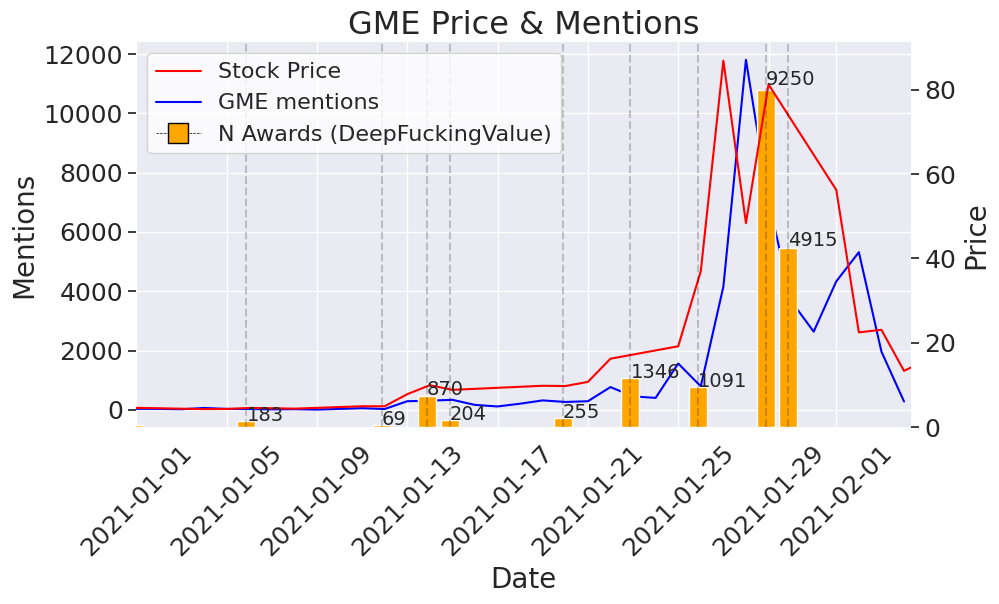

In [5]:
dfv=(df_post[df_post['author'] == 'DeepFuckingValue'].loc[df_post['created_utc']>datetime.datetime(2021, 1, 1, 0, 0)])

# twin y-axis 
sns.set_theme(style="darkgrid")
fig, ax1 = plt.subplots(figsize=(10,5))
sns.set_theme(style="white")
ax2 = ax1.twinx()

ax1.plot(gr.index,gr.values,color='blue')
ax2.plot(gme['date'],gme['Close'],color='red')
ax1.set_xlabel('Date',fontsize=20)
ax1.set_ylabel('Mentions',fontsize=20)
ax2.set_ylabel('Price',fontsize=20)

ax1.tick_params(axis='x', labelsize=18, rotation=45)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)

# ax1.set_yscale('log')
# ax2.set_yscale('log')

plt.bar(df_post[df_post['author'] == 'DeepFuckingValue']['created_utc'],df_post[df_post['author'] == 'DeepFuckingValue']['award_count']/(9250)*80,color='orange')
# text for each post from DeepFuckingValue
for i in range(len(dfv)):
    plt.text(dfv.iloc[i]['created_utc'],dfv.iloc[i]['award_count']/(9250)*81,int(dfv.iloc[i]['award_count']),fontsize=14)

plt.title('GME Price & Mentions',fontsize=23)
custom_scatter = [plt.Line2D([0], [0], color='red', markersize=8),
                    plt.Line2D([0], [0], color='blue', markersize=8),
                     plt.Line2D([0], [0], color='black',markerfacecolor='orange', label='N awards', markersize=15,marker='s',linewidth=0.5,linestyle='--')]
plt.legend(custom_scatter, ['Stock Price', 'GME mentions','N Awards (DeepFuckingValue)'],fontsize=16)

for i in range(len(df_post[df_post['author'] == 'DeepFuckingValue'])):
    plt.axvline(df_post[df_post['author'] == 'DeepFuckingValue'].iloc[i]['created_utc'], color='black', linestyle='--', alpha=0.2)

plt.xlim(datetime.datetime(2021, 1, 1, 0, 0), df_post['created_utc'].max())
sns.despine(left=True, bottom=True)
plt.show()
sns.set_theme(style="darkgrid")

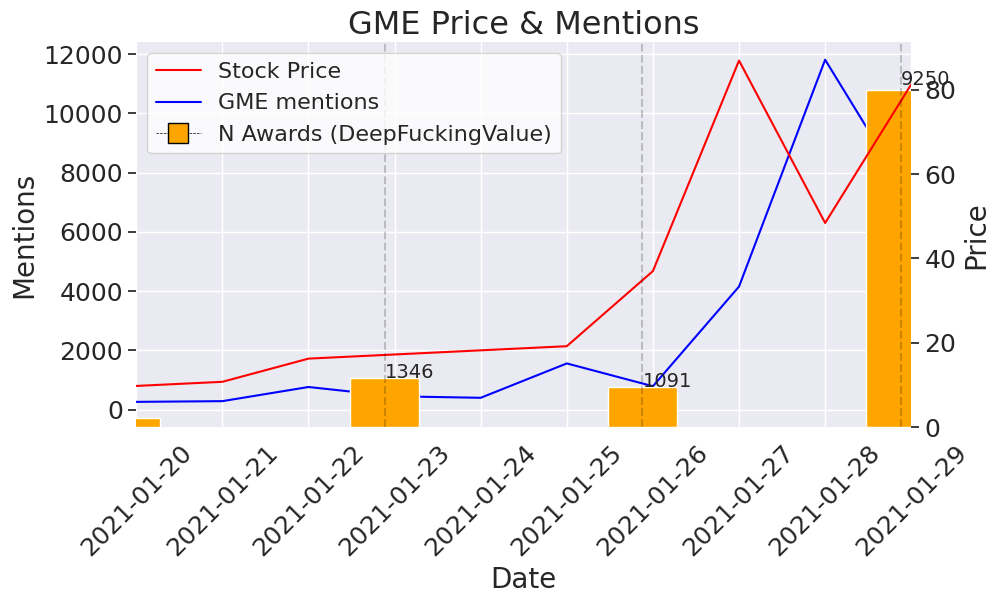

In [6]:
d_max = datetime.datetime(2021, 1, 29, 0, 0)
d_min = datetime.datetime(2021, 1, 20, 0, 0)

dfv=(df_post[df_post['author'] == 'DeepFuckingValue'].loc[df_post['created_utc']>d_min])
dfv=dfv.loc[dfv['created_utc']<d_max]

# twin y-axis 
sns.set_theme(style="darkgrid")
fig, ax1 = plt.subplots(figsize=(10,5))
sns.set_theme(style="white")
ax2 = ax1.twinx()

ax1.plot(gr.index,gr.values,color='blue')
ax2.plot(gme['date'],gme['Close'],color='red')
ax1.set_xlabel('Date',fontsize=20)
ax1.set_ylabel('Mentions',fontsize=20)
ax2.set_ylabel('Price',fontsize=20)

ax1.tick_params(axis='x', labelsize=18, rotation=45)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)

plt.bar(df_post[df_post['author'] == 'DeepFuckingValue']['created_utc'],df_post[df_post['author'] == 'DeepFuckingValue']['award_count']/(9250)*80,color='orange')
# text for each post from DeepFuckingValue
for i in range(len(dfv)):
    plt.text(dfv.iloc[i]['created_utc'],dfv.iloc[i]['award_count']/(9250)*81,int(dfv.iloc[i]['award_count']),fontsize=14)

plt.title('GME Price & Mentions',fontsize=23)
custom_scatter = [plt.Line2D([0], [0], color='red', markersize=8),
                    plt.Line2D([0], [0], color='blue', markersize=8),
                     plt.Line2D([0], [0], color='black',markerfacecolor='orange', label='N awards', markersize=15,marker='s',linewidth=0.5,linestyle='--')]
plt.legend(custom_scatter, ['Stock Price', 'GME mentions','N Awards (DeepFuckingValue)'],fontsize=16)

for i in range(len(df_post[df_post['author'] == 'DeepFuckingValue'])):
    plt.axvline(df_post[df_post['author'] == 'DeepFuckingValue'].iloc[i]['created_utc'], color='black', linestyle='--', alpha=0.2)

plt.xlim(d_min, d_max)
sns.despine(left=True, bottom=True)
plt.show()
sns.set_theme(style="darkgrid")

# Return 

In [7]:
dfv=(df_post[df_post['author'] == 'DeepFuckingValue'].loc[df_post['created_utc']>datetime.datetime(2021, 1, 1, 0, 0)])

In [8]:
dfv['date_no_time'] = pd.to_datetime(dfv['date_no_time'])
dfv['date_no_time'] = dfv['date_no_time'].dt.date
gme['string_date'] = gme['date'].astype(str)
gme['date']=gme['date'].dt.date

In [9]:
import random
def sample_random_date():
    max_date = dfv['date_no_time'].max()
    min_date = dfv['date_no_time'].min()
    random_date = min_date + datetime.timedelta(days=random.randint(0, (max_date - min_date).days))
    return random_date

def calculate_sum_return(dates,day):
    ROIs = []
    for date in dates:
        next_date = (date + datetime.timedelta(days=day))
        t = True
        while t:
            final = gme[gme['date']==next_date]
            if len(final)==0:
                # print(next_date.strftime("%A"))
                # print('added 1 day')
                next_date = next_date + datetime.timedelta(days=1)
            else:
                t=False
        
        t2 = True
        while t2:
            initial = gme[gme['date']==date]
            if len(initial)==0:
                # print(date.strftime("%A"))
                # print('added 1 day')
                date = date + datetime.timedelta(days=1)
            else:
                t2=False

        # print(date, next_date)

        ROI = (final['Close'].values[0]-initial['Close'].values[0])/initial['Close'].values[0]
        ROIs.append(ROI)
    return ROIs

In [10]:
ROIs=calculate_sum_return(dfv['date_no_time'],3)
print('ROIs: ', ROIs)
print('mean ROI: ', np.mean(ROIs))
print('std ROI: ', np.sum(ROIs))

ROIs:  [0.018422549186148544, 1.001504452281515, -0.013780988202539684, 0.25350321937978004, 0.6516768579300538, 0.18120286713129985, 1.5211616590092871, -0.3076923076923077, 0.1621900460049323]
mean ROI:  0.3853542616697966
std ROI:  3.468188355028169


100%|██████████| 2000/2000 [00:39<00:00, 51.02it/s]


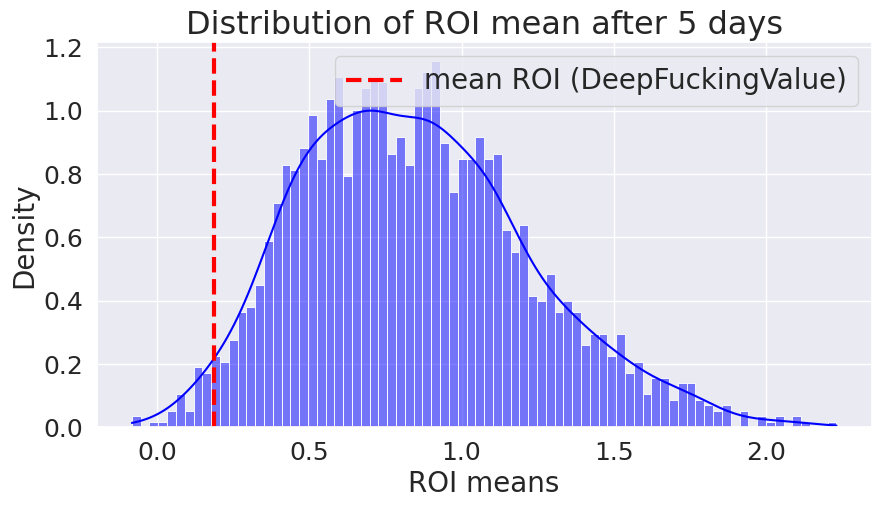

p-value:  0.979


In [13]:
ROIs_true=calculate_sum_return(dfv['date_no_time'],3)

ROIs_mean = []
for i in tqdm(range(2000)):
    random_dates = [sample_random_date() for i in range(len(dfv))]
    ROIs=calculate_sum_return(random_dates,5)
    ROIs_mean.append(np.mean(ROIs))

# plot distribution of ROIs
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,5))
sns.histplot(ROIs_mean, color='blue', bins=80, kde=True, stat='density', alpha=0.5)
# line
plt.axvline(np.mean(ROIs_true), color='red', linestyle='--', alpha=1, label='mean ROI (DeepFuckingValue)', linewidth=3)
plt.legend(fontsize=16)
plt.title('Distribution of ROI mean after 5 days',fontsize=23)
plt.legend(fontsize=20)
plt.xlabel('ROI means',fontsize=20)
plt.ylabel('Density',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

p_value = 1-(ROIs_mean < np.mean(ROIs_true)).sum()/len(ROIs_mean)
print('p-value: ', p_value)

100%|██████████| 2000/2000 [00:39<00:00, 51.04it/s]


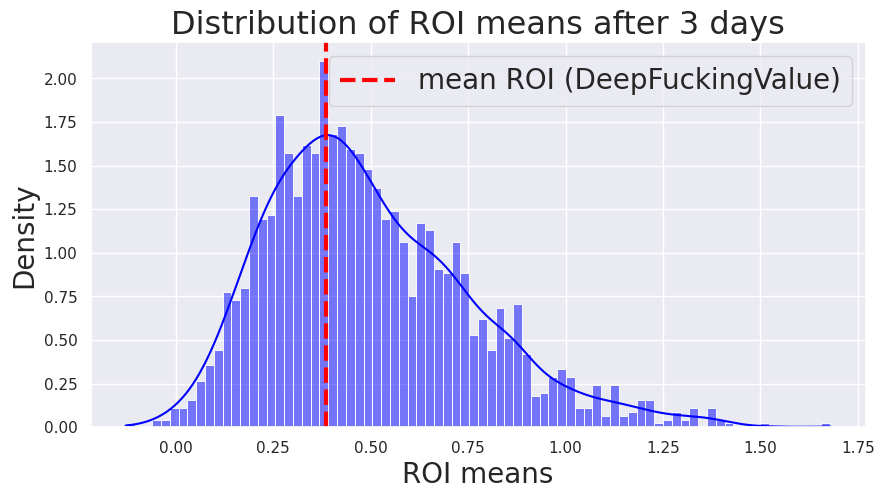

p-value:  0.616


In [15]:
ROIs_true=calculate_sum_return(dfv['date_no_time'],3)

ROIs_mean = []
for i in tqdm(range(2000)):
    random_dates = [sample_random_date() for i in range(len(dfv))]
    ROIs=calculate_sum_return(random_dates,3)
    ROIs_mean.append(np.mean(ROIs))

# plot distribution of ROIs
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,5))
sns.histplot(ROIs_mean, color='blue', bins=80, kde=True, stat='density', alpha=0.5)
# line
plt.axvline(np.mean(ROIs_true), color='red', linestyle='--', alpha=1, label='mean ROI (DeepFuckingValue)', linewidth=3)
plt.legend(fontsize=16)
plt.title('Distribution of ROI means after 3 days',fontsize=23)
plt.legend(fontsize=20)
plt.xlabel('ROI means',fontsize=20)
plt.ylabel('Density',fontsize=20)
plt.savefig('/home/pelle/Master_Thesis/reports/figures/ROI_3_days.png', dpi=250)
plt.show()

p_value = 1-(ROIs_mean < np.mean(ROIs_true)).sum()/len(ROIs_mean)
print('p-value: ', p_value)